<a href="https://colab.research.google.com/github/shreyasmiraj/Music_Spectrogram_GAN/blob/main/Spectogram_Music_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
!pip install wandb --quiet
!pip install carbontracker --quiet

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     |████████████████████████████████| 26.9 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 8.9 MB/s 
     |████████████████████████████████| 170 kB 87.1 MB/s 
     |████████████████████████████████| 97 kB 8.9 MB/s 
     |████████████████████████████████| 133 kB 88.2 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 98 kB 6.3 MB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 


In [ ]:
#@title Library imports
import os
import glob
import sys
import cv2
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import Compose
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
from google.colab import drive
import PIL
import sklearn
import wandb
from torchvision import models
from torchsummary import summary
import h5py
import sklearn
from carbontracker.tracker import CarbonTracker
import plotly.express as px
import pandas as pd

In [ ]:
#@title Helper functions

def slice_music(window_len, original_data_path, sliced_data_path):
  """
    Args:
        windows_len (int): size of music to sample in sec
        original_data_path (str): path to songs data folder
        sliced_data_path (str): path to where the shortened images of length n are to be stored
    Return:
        timeseries_data (ndarray):contains sequence of shortened timeseries data,
        timeseries_genre_label (ndarray): contains genre labels mapped to data index}
  """
  if os.path.exists(sliced_data_path) == False:
    os.mkdir(sliced_data_path)
  genres = os.listdir(original_data_path)
  timeseries = {}
  timeseries_data = []
  timeseries_genre_label = []
  timeseries_index = 0
  for genre in genres:
    songs = os.listdir(original_data_path+'/'+genre)
    for song in tqdm(songs):
      try:
        y, sample_rate = librosa.load(original_data_path+'/'+genre+'/'+song)
        iter = 0
        window_size = int(len(y)*window_len/30)
        count = 0
        fig = plt.figure(figsize=(10, 10))
        while iter <= len(y)-window_size:
          sample = y[iter:iter+window_size]
          S = librosa.feature.melspectrogram(sample, sr=sample_rate)
          S_DB = librosa.amplitude_to_db(S, ref=np.max)
          librosa.display.specshow(S_DB, sr=sample_rate, hop_length=512)
          ax = plt.axes([0,0,1,1])
          plt.axis("off")
          plt.savefig(sliced_data_path+'/'+str(timeseries_index)+'.png',bbox_inches=0,pad_inches=0)
          plt.clf()
          plt.ioff()
          iter += window_size
          count += 1
          timeseries_data.append(sample)
          timeseries_index += 1
          timeseries_genre_label.append(genre)
        plt.close(fig)
      except Exception as e:
        print("Encountered error at: "+original_data_path+'/'+genre+'/'+song)
        print(e)
  return np.array(timeseries_data),np.array(timeseries_genre_label)

def save_data(file_name, save_path, data=None, data_folder=None):
  """
    Args:
      file_name (str): output/target file name
      save_path (str path): output/target path
      data (any object): any python object to be saved
      data_folder (str path): path of folder to zip and save

      #Deletes temporary copies of file created
  """
  from google.colab import drive
  import pickle
  import shutil
  import zipfile
  drive.mount('/content/drive')
  if type(data) != type(None):
    pickle_file = file_name+'.pickle'
    with open(pickle_file,'wb') as handle:
      pickle.dump(data, handle)
    shutil.copy(pickle_file, save_path)
    os.remove(pickle_file)
  if type(data_folder) != type(None):
    if os.path.isdir(data_folder):
      path = data_folder
      zip_file = file_name + '.zip'
      zipf = zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED)
      for root, dirs, files in os.walk(path):
          for file in tqdm(files):
              zipf.write(os.path.join(root, file),
                        os.path.relpath(os.path.join(root, file),
                                        os.path.join(path, '..')))
      zipf.close()
      shutil.copy(zip_file,save_path)
      os.remove(zip_file)
  drive.flush_and_unmount()

def load_pickle(path):
  """
    Args:
      path (str): path to the pickle file/binary object to load
    Returns:
      object stored in the pickle file
  """
  import pickle
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  local_tmp = '/content/tmp'
  if os.path.exists(local_tmp):
    os.remove(local_tmp)
  f = open(local_tmp,'x')
  f.close()
  shutil.copy(path,local_tmp)
  obj = None
  with open(local_tmp, 'rb') as handle:
    obj = pickle.load(handle)
  os.remove(local_tmp)
  drive.flush_and_unmount()
  return obj

def load_zip(src_path, dest_path=None):
  """
    Args:
      src_path (str): path to the file to load, include file/folder name
      dest_path (str): path to destination, include file/folder name
  """
  from google.colab import drive
  import zipfile
  import shutil
  import os

  drive.mount('/content/drive')
  cwd = os.getcwd()
  local_tmp = '/content/tmp'
  if os.path.exists(local_tmp):
    os.remove(local_tmp)
  f = open(local_tmp,'x')
  f.close()
  shutil.copy(src_path, local_tmp)
  with zipfile.ZipFile(local_tmp, 'r') as zipObj:
    zipObj.extractall(dest_path)
  os.remove(local_tmp)
  drive.flush_and_unmount()

def find_image_content_index(path_to_image):
  """
    Extracts indexs of image if it has boundary based on mean of row/column content
    Args:
      path_to_image(str): path to image to extract the index start and end in image
    Returs:
      row_start, row_end, column_start, column_end(int): content index boundaries
  """
  row_start = 0
  row_end = 0
  column_start = 0
  column_end = 0
  test_data = imageio.imread(path_to_image)
  row_null = np.sum(np.mean(test_data[0][0]))
  column_null = np.sum(np.mean(test_data[0][0]))
  row_flag = False
  column_flag = False
  for row in range(test_data.shape[0]):
    col = row
    row_sum = np.sum(np.mean(test_data[row]))
    column_sum = np.sum(np.mean(test_data[:][col]))
    if(row_sum != row_null and row_flag == False):
      row_start = row
      row_flag = True
    if(row_sum == row_null and row_flag == True):
      row_end = row
    if(column_sum != column_null and column_flag == False):
      column_start = col
      column_flag = True
    if(column_sum == column_null and column_flag == True):
      column_end = col
    if(column_flag and row_flag and column_end != 0 and row_end !=0):
      return row_start,row_end,column_start,column_end
  return 0,0,0,0


def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()


def set_device():
  """
    Returns:
      device (str): runtime device "cuda" if available else "cpu"
  """
  device = None
  if torch.cuda.is_available:
    device = "cuda"
  else:
    device = "cpu"
    print("WARNING GPU UNAVAILABLE, change runtime to GPU")
  return device


def save_model(model, path):
  """
    Args:
      model (nn.module class instance)
      path (str, path)
  """
  drive.mount('/content/drive')
  torch.save(model.state_dict(), path)
  drive.flush_and_unmount()

def load_model(model, path):
  """
    Args:
      model (nn.module class instance)
      path (str path)

    Usage
    model = MyModelDefinition(args)
  """
  drive.mount('/content/drive')
  model.load_state_dict(torch.load(path))
  drive.flush_and_unmount()

def create_video(path):
  init_frame = 1 #This is the frame where the video will start
  last_frame = i #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

  min_fps = 10
  max_fps = 60

  total_frames = last_frame-init_frame

  length = 15 #Desired time of the video in seconds

  frames = []
  tqdm.write('Generating video...')
  for i in range(init_frame,last_frame): #
      frames.append(imageio.Image.open(path+'/'+ str(i) +'.png'))

  #fps = last_frame/10
  fps = np.clip(total_frames/length,min_fps,max_fps)

  from subprocess import Popen, PIPE
  p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
  for im in tqdm(frames):
      im.save(p.stdin, 'PNG')
  p.stdin.close()
  p.wait()

## Paths
### Define all paths/file references here

# Please use indecisivesalmons496@gmail.com for this drive

In [ ]:
drive_path = '/content/drive/MyDrive/'
nma_data = '/content/Data/'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Download and extract NMA data if required

In [ ]:
# # @markdown - [ ] No need to run this cell if you are using augmented data from drive
# # @markdown - [x] Run the helper and Load data from drive instead
# import requests

# fname = "music.zip"
# url = "https://osf.io/drjhb/download"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       with open(fname, "wb") as fid:
#         fid.write(r.content)

# from zipfile import ZipFile

# with ZipFile(fname, 'r') as zipObj:
#   # Extract all the contents of zip file in different directory
#   zipObj.extractall()

## Augment and create new Dataset
  - slicing original wav data to set window_len
  - includes reshaping of images into 300*450
  - removal of borders
  - label stratified directory structure
  - sliced timseries, labels(both as numpy objects in pickle files) and images store(in zip format with the same directory structure)


**Run this only to create new dataset, requires data downloaded from NMA source**


In [ ]:
#@title Helper functions

def slice_music(window_len, original_data_path, sliced_data_path):
    """
    Args:
        windows_len (int): size of music to sample in sec
        original_data_path (str): path to songs data folder
        sliced_data_path (str): path to where the shortened images of length n are to be stored
    Return:
        timeseries_data (ndarray):contains sequence of shortened timeseries data,
        timeseries_genre_label (ndarray): contains genre labels mapped to data index}
  """
  if os.path.exists(sliced_data_path):
    shutil.rmtree(sliced_data_path)
  os.mkdir(sliced_data_path)
  genres = os.listdir(original_data_path)
  timeseries = {}
  timeseries_data = []
  timeseries_genre_label = []
  timeseries_index = 0
  for genre in genres:
    songs = os.listdir(original_data_path+'/'+genre)
    for song in tqdm(songs):
      try:
        y, sample_rate = librosa.load(original_data_path+'/'+genre+'/'+song)
        iter = 0
        window_size = int(len(y)*window_len/30)
        count = 0
        fig = plt.figure(figsize=(15, 10),frameon=False)
        while iter <= len(y)-window_size:
          sample = y[iter:iter+window_size]
          S = librosa.feature.melspectrogram(sample, sr=sample_rate)
          S_DB = librosa.amplitude_to_db(S, ref=np.max)
          librosa.display.specshow(S_DB, sr=sample_rate, hop_length=512)
          # ax = plt.axes([0,0,1,1])
          plt.axis("off")
          plt.savefig(sliced_data_path+'/'+str(timeseries_index)+'.png',bbox_inches='tight',pad_inches=0)
          plt.clf()
          plt.ioff()
          iter += window_size
          count += 1
          timeseries_data.append(sample)
          timeseries_genre_label.append(genre)
          timeseries_index += 1
        plt.close(fig)
      except Exception as e:
        print("Encountered error at: "+original_data_path+'/'+genre+'/'+song)
        print(e)
  return np.array(timeseries_data,dtype=type(timeseries_data[0])),np.array(timeseries_genre_label)

def save_data(file_name, save_path, data=None, data_folder=None):
  """
    Args:
      file_name (str): output/target file name
      save_path (str path): output/target path
      data (any object): any python object to be saved
      data_folder (str path): path of folder to zip and save

      #Deletes temporary copies of file created
  """
  from google.colab import drive
  import pickle
  import shutil
  import zipfile
  drive.mount('/content/drive')
  if type(data) != type(None):
    pickle_file = file_name+'.pickle'
    with open(pickle_file,'wb') as handle:
      pickle.dump(data, handle)
    shutil.copy(pickle_file, save_path)
    os.remove(pickle_file)
  if type(data_folder) != type(None):
    if os.path.isdir(data_folder):
      path = data_folder
      zip_file = file_name + '.zip'
      zipf = zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED)
      for root, dirs, files in os.walk(path):
          for file in tqdm(files):
              zipf.write(os.path.join(root, file),
                        os.path.relpath(os.path.join(root, file),
                                        os.path.join(path, '..')))
      zipf.close()
      shutil.copy(zip_file,save_path)
      os.remove(zip_file)
  drive.flush_and_unmount()

def load_pickle(path):
  """
    Args:
      path (str): path to the pickle file/binary object to load
    Returns:
      object stored in the pickle file
  """
  import pickle
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  local_tmp = '/content/tmp'
  f = open(local_tmp,'x')
  f.close()
  shutil.copy(path,local_tmp)
  obj = None
  with open(local_tmp, 'rb') as handle:
    obj = pickle.load(handle)
  os.remove(local_tmp)
  drive.flush_and_unmount()
  return obj

def load_zip(src_path, dest_path=None):
  """
    Args:
      src_path (str): path to the file to load, include file/folder name
      dest_path (str): path to destination, include file/folder name
  """
  from google.colab import drive
  import zipfile
  import shutil
  import os

  drive.mount('/content/drive')
  cwd = os.getcwd()
  local_tmp = '/content/tmp'
  f = open(local_tmp,'x')
  f.close()
  shutil.copy(src_path, local_tmp)
  with zipfile.ZipFile(local_tmp, 'r') as zipObj:
    zipObj.extractall(dest_path)
  os.remove(local_tmp)
  drive.flush_and_unmount()

def find_image_content_index(path_to_image):
  """
    Extracts indexs of image if it has boundary based on mean of row/column content
    Args:
      path_to_image(str): path to image to extract the index start and end in image
    Returs:
      row_start, row_end, column_start, column_end(int): content index boundaries
  """
  row_start = 0
  row_end = 0
  column_start = 0
  column_end = 0
  test_data = imageio.imread(path_to_image)
  row_null = np.sum(np.mean(test_data[0][0]))
  column_null = np.sum(np.mean(test_data[0][0]))
  row_flag = False
  column_flag = False
  for row in range(test_data.shape[0]):
    col = row
    row_sum = np.sum(np.mean(test_data[row]))
    column_sum = np.sum(np.mean(test_data[:][col]))
    if(row_sum != row_null and row_flag == False):
      row_start = row
      row_flag = True
    if(row_sum == row_null and row_flag == True):
      row_end = row
    if(column_sum != column_null and column_flag == False):
      column_start = col
      column_flag = True
    if(column_sum == column_null and column_flag == True):
      column_end = col
    if(column_flag and row_flag and column_end != 0 and row_end !=0):
      return row_start,row_end,column_start,column_end
  return 0,test_data.shape[0]-1,0,test_data.shape[1]-1


def extract_spectogram_labels(window_len, original_data_path, sliced_data_path):
  timeseries_data, timeseries_label = slice_music(window_len, original_data_path, sliced_data_path)
  labels_dict = {'blues': 0,
               'jazz': 1,
               'country': 2,
               'hiphop':3,
               'metal':4,
               'reggae':5,
               'classical':6,
               'disco':7,
               'pop':8,
               'rock':9}
  for i in range(timeseries_label.shape[0]):
    timeseries_label[i] = labels_dict[timeseries_label[i]]
  timeseries_label = timeseries_label.astype('int64')
  save_data('sliced_timeseries_numpy','/content/drive/MyDrive/',data=timeseries_data)
  return timeseries_label

def extract_spectogram_data(sliced_data_path, height, width,n_channels=4):
  spectogram_data = []
  row_start, row_end, column_start, column_end = find_image_content_index('/content/sliced_dataset/0.png')
  for root,dirs,images in os.walk(sliced_data_path):
    for image in tqdm(images):
      image_data = cv2.imread(root+'/'+image)
      # slice_im_data = image_data[row_start:row_end][column_start:column_end]
      img_resized = cv2.resize(image_data, (width, height))
      spectogram_data.append(img_resized)
  spectogram_data = np.asarray(spectogram_data)
  spectogram_data = spectogram_data[:,:,:,0:n_channels]
  return spectogram_data

def create_images(spectogram_data,spectogram_label):
  labels_dict = {'blues': 0,
              'jazz': 1,
              'country': 2,
              'hiphop':3,
              'metal':4,
              'reggae':5,
              'classical':6,
              'disco':7,
              'pop':8,
              'rock':9}
  label_keys = list(labels_dict.keys())
  dataset_path = '/content/dataset'
  if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
  os.mkdir(dataset_path)
  for iter in tqdm(range(len(spectogram_data))):
    if os.path.exists(dataset_path+'/'+label_keys[spectogram_label[iter]]):
      im = PIL.Image.fromarray(spectogram_data[iter])
      im.save(dataset_path+'/'+label_keys[spectogram_label[iter]]+'/'+str(iter)+'.png')
    else:
      os.mkdir(dataset_path+'/'+label_keys[spectogram_label[iter]])
      im = PIL.Image.fromarray(spectogram_data[iter])
      im.save(dataset_path+'/'+label_keys[spectogram_label[iter]]+'/'+str(iter)+'.png')

def reformat_spectogram_data(spectogram_data):
  spectogram_data = np.swapaxes(spectogram_data, 3, 2)
  spectogram_data = np.swapaxes(spectogram_data, 2, 1)
  spectogram_data = spectogram_data.astype('float32')
  return spectogram_data

def create_hdf5(data, data_label, dest_path):
  if os.path.exists(dest_path):
    shutil.rmtree(dest_path)
  os.mkdir(dest_path)
  if os.path.exists(dest_path+'numpy_spec_f32_label_d64.h5'):
    os.remove(dest_path+'numpy_spec_f32_label_d64.h5')
  hf = h5py.File(dest_path+'numpy_spec_f32_label_d64.h5','w')
  hf.create_dataset('images',data=data)
  hf.create_dataset('labels',data=data_label)

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

def set_device():
  """
    Returns:
      device (str): runtime device "cuda" if available else "cpu"
  """
  device = None
  if torch.cuda.is_available:
    device = "cuda"
  else:
    device = "cpu"
    print("WARNING GPU UNAVAILABLE, change runtime to GPU")
  return device

In [ ]:
window_len = 3 #create 3s sized samples
original_data_path = '/content/Data/genres_original'
sliced_data_path = '/content/sliced_dataset'

spectogram_label = extract_spectogram_labels(window_len,original_data_path,sliced_data_path)
spectogram_data = extract_spectogram_data(sliced_data_path, 300, 450, n_channels=3)

In [ ]:
save_data('spectogram_data','/content/drive/MyDrive/',data=spectogram_data)
save_data('spectogram_label','/content/drive/MyDrive',data=spectogram_label)
create_images(spectogram_data,spectogram_label)
save_data('latest_spec_dataset','/content/drive/MyDrive/',data_folder='/content/dataset/')

In [ ]:
def spec_data_label():
  labels_dict = {'blues': 0,
              'jazz': 1,
              'country': 2,
              'hiphop':3,
              'metal':4,
              'reggae':5,
              'classical':6,
              'disco':7,
              'pop':8,
              'rock':9}
  spectogram_data_permute = []
  spectogram_label = []
  genres = os.listdir('/content/dataset/')

  for genre in genres:
    images = os.listdir('/content/dataset'+'/'+genre)
    for image in tqdm(images):
      im_data = cv2.imread('/content/dataset'+'/'+genre+'/'+image)
      im_data = torch.from_numpy(im_data).permute(2,0,1).numpy()
      spectogram_data_permute.append(im_data)
      spectogram_label.append(int(labels_dict[genre]))

  return spectogram_data, spectogram_label



del spectogram_data
del spectogram_label
del spectogram_data_permute



spectogram_data_permute = spec_data_label()
# spectogram_data_permute = np.array(spectogram_data_permute)
# spectogram_label = np.array(spectogram_label).astype('int64')
shutil.rmtree('/content/latest_hdf5_dataset')
os.mkdir('/content/latest_hdf5_dataset')
hf = h5py.File('/content/latest_hdf5_dataset/'+'numpy_spec_f32_label_d64.h5','w')
hf.create_dataset('images',data=spectogram_data_permute)

del spectogram_data_permute

spectogram_label = spec_data_label()

hf.create_dataset('labels',data=spectogram_label)
del spectogram_label

hf.close()

create_hdf5(spectogram_data_permute,spectogram_label,'/content/latest_hdf5_dataset/')
save_data('latest_hdf5_dataset','/content/drive/MyDrive/',data_folder='/content/latest_hdf5_dataset/')


In [ ]:
audio_timeseries = load_pickle(drive_path+'sliced_timeseries_numpy.pickle')
audio_labels = load_pickle(drive_path+'spectogram_label.pickle')

min_size = np.array([a.shape[0] for a in audio_timeseries]).min()
min_sized_audio = []
for a in audio_timeseries:
  min_sized_audio.append(a[:min_size].astype('float32'))
del audio_timeseries
audio_dataset_path = '/content/audio_hdf5_dataset/'
if os.path.exists(audio_dataset_path):
  shutil.rmtree(audio_dataset_path)
os.mkdir(audio_dataset_path)
hf = h5py.File(audio_dataset_path+'audio_f32_label_d64.h5','w')
hf.create_dataset('audio',data=min_sized_audio)
hf.create_dataset('labels',data=audio_labels.astype('int64'))
hf.close()

save_data('audio_hdf5_dataset',drive_path, data_folder=audio_dataset_path)

##  Data Split and Loader


#### Torchvision ImageFolder dataloader

- Loads labels automatically based on directory structure in the dataset folder
- slows down training as reading from images takes up 80% of train time

In [ ]:
# @title do not use this dataloader(3x SLOWER) if you have access to numpy hdf5 image dataset
def loader(path):
    return cv2.imread(path,flags=cv2.IMREAD_UNCHANGED)
device = set_device()
generator = torch.Generator(device="cpu")
generator.manual_seed(42)
dataset = datasets.ImageFolder('Data/images_original/',transform=Compose([transforms.ToTensor(),transforms.Resize((288, 432))]))
# dataset = datasets.DatasetFolder('dataset', loader, extensions=('.png'), transform=Compose([transforms.ToTensor(),transforms.Resize((300,450)),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))]))
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


batch_size = 25

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, generator=generator)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, generator=generator)

#### NMA DATA LOADER

In [ ]:
load_zip(drive_path+'latest_spec_dataset.zip')

Mounted at /content/drive


In [ ]:
for root, dirs, images in os.walk('/content/dataset'):
  print(len(images))

0
1000
1000
1000
1000
1000
1000
1000
1000
990
1000


In [ ]:
device = set_device()
generator = torch.Generator(device="cpu")
generator.manual_seed(42)
spectrograms_dir = "/content/dataset"
folder_names = ['/content/dataset2/train/', '/content/dataset2/test/', '/content/dataset2/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

if os.path.exists('/content/dataset2'):
  shutil.rmtree('/content/dataset2')
  os.mkdir('/content/dataset2')
else:
  os.mkdir('/content/dataset2')
for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))



train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

validation_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=True, num_workers=0)

#### Custom HDF5 DATA LOADER
- faster load times(reduces train time by ~60%)
- Requires explict label mapping and storage of image data(numpy as float32) and labels(numpy as int64) into a hdf5 dataset with two dataset names 'images' and 'labels'.
- Image needs to be in the format of bath_size,C,H,W for torch conv

In [ ]:
load_zip(drive_path+'latest_hdf5_dataset.zip')

Mounted at /content/drive


In [ ]:
# from IPython import display
# import time

# for root, dirs, images in os.walk('/content/dataset/'):
#   for image in images:
#     im = cv2.imread(root+'/'+image)
#     plt.imshow(im)
#     plt.title(dir+str(im.shape))
#     plt.axis('off')
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     time.sleep(0.01)

In [ ]:
# im = cv2.imread('/content/dataset/blues/8241.png')
# plt.imshow(im)
# plt.axis('off')

In [ ]:
class custom_h5_dataset(torch.utils.data.Dataset):
  def __init__(self, in_file, normalize = True, to_tensor = True, n_channels = 3):
      super(custom_h5_dataset, self).__init__()

      self.file = h5py.File(in_file, 'r')
      self.n_images, self.channels, self.height, self.width = self.file['images'].shape
      self.n_labels = self.file['labels'].shape[0]
      self.normalize = normalize
      self.n_channels = n_channels
      self.to_tensor = to_tensor
      assert self.n_images == self.n_labels

  def __getitem__(self, index):
      data = self.file['images'][index,:,:,:]
      label = self.file['labels'][index]
      data = torch.from_numpy(data.astype('float32'))
      return data, label

  def __len__(self):
      return self.n_images

  def labels(self):
    return self.file['labels']

In [ ]:
def data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator, epoch_count=0):

  genres = dataset.labels()
  last_genre = genres[0]
  genre_index_split = []

  for i,genre in enumerate(genres):
    if genre != last_genre:
      last_genre = genre
      genre_index_split.append(i)
  genre_index_split.append(len(genres))

  # print(genre_index_split)

  dataset_size = len(dataset)
  indices = list(range(dataset_size))

  # genre_index_split = [1000, 2000, 3000, 4000, 5000, 6000, 6990, 7990, 8990, 9990]
  shuffle_dataset = True
  batch_size = batch_size

  train_indices, val_indices, test_indices = [],[],[]

  if shuffle_dataset :
    np.random.seed(seed)
    # np.random.shuffle(indices)
    last_index = 0
    for index in genre_index_split:
      test_array = []
      genre_indices = list(range(last_index,index))
      indices_length = len(genre_indices)

      train_size = int(train_split * indices_length)
      val_size = int(val_split * indices_length)
      test_size = indices_length - train_size - val_size

      train_start = 0
      train_end = train_start+train_size
      val_start = train_end
      val_end = val_start+val_size
      test_start = val_end
      test_end = test_start+test_size

      np.random.shuffle(genre_indices)
      for i in genre_indices[train_start:train_end]:
        train_indices.append(i)
      for i in genre_indices[val_start:val_end]:
        test_array.append(i)
        val_indices.append(i)
      for i in genre_indices[test_start:test_end]:
        test_indices.append(i)
      last_index = index
      # print(len(genre_indices))
      # print(len(train_indices),len(val_indices),len(test_indices))
      # print(test_array[:20])

  # Creating PT data samplers and loaders:
  train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices, generator=generator)
  valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices, generator=generator)
  test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices, generator=generator)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=0)
  return train_loader, validation_loader, test_loader


def view_data_loader(loader):
  labels_dict = {'blues': 0,
            'jazz': 1,
            'country': 2,
            'hiphop':3,
            'metal':4,
            'reggae':5,
            'classical':6,
            'disco':7,
            'pop':8,
            'rock':9}
  label_keys = labels_dict.keys()
  dataset = iter(loader)
  from IPython import display
  import time
  i = 0
  while i < len(dataset):
    data, label = dataset.next()
    for d in range(data.shape[0]):
      plt.imshow(data[d].permute(1,2,0))
      plt.title(label_keys[label[d]])
      display.clear_output(wait=True)
      display.display(plt.gcf())
    i += 1
    print(i)

labels_dict = {'blues': 0,
            'jazz': 1,
            'country': 2,
            'hiphop':3,
            'metal':4,
            'reggae':5,
            'classical':6,
            'disco':7,
            'pop':8,
            'rock':9}
label_keys = list(labels_dict.keys())
label_values = list(labels_dict.values())

audio_file_map = load_pickle('/content/drive/MyDrive/sliced_audio_name.pickle')

Mounted at /content/drive


In [ ]:
# view_loader_data(train_loader)

## Convolutional Classifier

### Music Net - NMA

In [ ]:
# Make a CNN & train it to predict genres.
class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    # self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)

    #Need to decide on input size, currently its 300*450
    #output_pixels = input_pixels - sum((-kernel_size[i]+1(bias))/stride)
    #infeatures will change based on
    ## in_features = out_channels*(output_pixels*output_pixels)
    # should this be multiplied with no. of color channels?

    self.fc1 = nn.Linear(in_features= 10752, out_features=10)
    # self.fc2 = nn.Linear(in_features = 1024, out_features=512)
    # self.fc3 = nn.Linear(in_features = 512, out_features=256)
    # self.fc4 = nn.Linear(in_features = 256, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)
    # self.batchnorm6 = nn.BatchNorm2d(num_features=256)
    self.dropout = nn.Dropout(p=0.3, inplace=False)

    self.relu = torch.nn.functional.relu
    self.mish = torch.nn.functional.mish
    self.lrelu = torch.nn.functional.leaky_relu

    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    # torch.nn.init.xavier_normal_(self.fc2.weight)
    # torch.nn.init.xavier_normal_(self.fc3.weight)
    # torch.nn.init.xavier_normal_(self.fc4.weight)

  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    x = torch.nn.functional.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.relu(x)
    x = torch.nn.functional.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = self.relu(x)
    x = torch.nn.functional.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = self.relu(x)
    x = torch.nn.functional.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = self.relu(x)
    x = torch.nn.functional.max_pool2d(x, kernel_size=2)

    # # Conv layer 6.
    # x = self.conv6(x)
    # x = self.batchnorm6(x)
    # x = self.relu(x)
    # x = torch.nn.functional.avg_pool2d(x, kernel_size=2)

    #Flatten Conv layers
    x = torch.flatten(x, 1) # => 6*6*128

    # Fully connected layers
    x = self.dropout(x)
    x = self.fc1(x)
    # x = self.relu(x)
    # x = self.fc2(x)
    # x = self.relu(x)
    # x = self.fc3(x)
    # x = self.relu(x)
    # x = self.fc4(x)
    x = F.softmax(x)

    return x

#plot - accuracy histogram per genre
#dense_layer output for clustering analysis
#hyperparameter tuning
#decide on size of music to be subsampled
#log classes that are misclassified

### Deep music net

In [ ]:
# Make a CNN & train it to predict genres.
class deep_music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(deep_music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    # self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)

    #Need to decide on input size, currently its 300*450
    #output_pixels = input_pixels - sum((-kernel_size[i]+1(bias))/stride)
    #infeatures will change based on
    ## in_features = out_channels*(output_pixels*output_pixels)
    # should this be multiplied with no. of color channels?

    self.fc1 = nn.Linear(in_features= 10752, out_features=1024)
    self.fc2 = nn.Linear(in_features = 1024, out_features=512)
    self.fc3 = nn.Linear(in_features = 512, out_features=256)
    self.fc4 = nn.Linear(in_features = 256, out_features=10)
    # self.fc5 = nn.Linear(in_features = 128, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)
    # self.batchnorm6 = nn.BatchNorm2d(num_features=256)
    self.dropout = nn.Dropout(p=0.3, inplace=False)
    self.fcdropout = nn.Dropout(p=0.5, inplace=False)
    self.relu = torch.nn.functional.relu
    self.mish = torch.nn.functional.mish
    self.lrelu = torch.nn.functional.leaky_relu

    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.xavier_normal_(self.fc4.weight)


  def forward(self, x, embeddings=False, conv_embeddings=False):
    embeddings_dict = {}
    if embeddings:
      fc1, fc2, fc3, fc4 = None, None, None, None
    if conv_embeddings:
      conv1,conv2,conv3,conv4,conv5 = None, None, None, None, None
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.mish(x)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    if conv_embeddings:
      conv1 = x.detach().cpu().numpy()
    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.mish(x)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    if conv_embeddings:
      conv2 = x.detach().cpu().numpy()
    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = self.mish(x)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    if conv_embeddings:
      conv3 = x.detach().cpu().numpy()
    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = self.mish(x)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    if conv_embeddings:
      conv4 = x.detach().cpu().numpy()
    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = self.mish(x)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    if conv_embeddings:
      conv5 = x.detach().cpu().numpy()
    # # Conv layer 6.
    # x = self.conv6(x)
    # x = self.batchnorm6(x)
    # x = self.relu(x)
    # x = torch.nn.functional.avg_pool2d(x, kernel_size=2)

    #Flatten Conv layers
    x = torch.flatten(x, 1) # => 6*6*128

    x = self.dropout(x)

    # Fully connected layers
    x = self.fc1(x)
    x = self.mish(x)
    if embeddings:
      fc1 = x.detach().cpu().numpy()
    x = self.fcdropout(x)
    x = self.fc2(x)
    x = self.mish(x)
    if embeddings:
      fc2 = x.detach().cpu().numpy()
    x = self.fcdropout(x)
    x = self.fc3(x)
    x = self.mish(x)
    if embeddings:
      fc3 = x.detach().cpu().numpy()
    x = self.fcdropout(x)
    x = self.fc4(x)
    # x = self.mish(x)
    if embeddings:
      fc4 = x.detach().cpu().numpy()
    # x = self.fc5(x)
    # if embeddings:
    #   fc5 = x.detach().cpu().numpy()

    x = F.softmax(x,dim=1)
    if embeddings:
      embeddings_dict.update({'fc1':fc1,
                              'fc2':fc2,
                              'fc3':fc3,
                              'fc4':fc4})
    if conv_embeddings:
      embeddings_dict.update({'conv1':conv1,
                              'conv2':conv2,
                              'conv3':conv3,
                              'conv4':conv4,
                              'conv5':conv5})
    if embeddings or conv_embeddings:
      return x, embeddings_dict
    return x

### Deep music net tempoz

In [ ]:
# Make a CNN & train it to predict genres.
class deep_music_net_tempoz(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(deep_music_net_tempoz, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)  # =>    x,   y,  z
                                                                                              #      |_|,   ||, ==

    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)

    self.conv_v_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(6,3), stride=1, padding=0)
    self.conv_v_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(6,3), stride=1, padding=0)
    self.conv_v_4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(6,3), stride=1, padding=0)
    self.conv_v_5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(6,3), stride=1, padding=0)

    self.conv_h_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,6), stride=1, padding=0)
    self.conv_h_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,6), stride=1, padding=0)
    self.conv_h_4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,6), stride=1, padding=0)
    self.conv_h_5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,6), stride=1, padding=0)



    #Need to decide on input size, currently its 300*450
    #output_pixels = input_pixels - sum((-kernel_size[i]+1(bias))/stride)
    #infeatures will change based on
    ## in_features = out_channels*(output_pixels*output_pixels)
    # should this be multiplied with no. of color channels?

    self.fc1 = nn.Linear(in_features=26880, out_features=10240)
    self.fc2 = nn.Linear(in_features = 10240, out_features=1024)
    self.fc3 = nn.Linear(in_features = 1024, out_features=512)
    self.fc4 = nn.Linear(in_features = 512, out_features=256)
    self.fc5 = nn.Linear(in_features = 256, out_features=10)
    #self.fc6 = nn.Linear(in_features = 128, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)
    # self.batchnorm6 = nn.BatchNorm2d(num_features=256)
    self.dropout = nn.Dropout(p=0.3, inplace=False)

    self.relu = torch.nn.functional.relu
    self.mish = torch.nn.functional.mish
    self.lrelu = torch.nn.functional.leaky_relu


    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv_v_2.weight)
    torch.nn.init.xavier_normal_(self.conv_v_3.weight)
    torch.nn.init.xavier_normal_(self.conv_v_4.weight)
    torch.nn.init.xavier_normal_(self.conv_v_5.weight)
    torch.nn.init.xavier_normal_(self.conv_h_2.weight)
    torch.nn.init.xavier_normal_(self.conv_h_3.weight)
    torch.nn.init.xavier_normal_(self.conv_h_4.weight)
    torch.nn.init.xavier_normal_(self.conv_h_5.weight)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.xavier_normal_(self.fc4.weight)
    torch.nn.init.xavier_normal_(self.fc5.weight)


  def forward(self, i, embeddings=False):
    # Conv layer 1.
    i = self.conv1(i)
    i = self.batchnorm1(i)
    i = self.relu(i)
    i = torch.nn.functional.avg_pool2d(i, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(i)
    v = self.conv_v_2(i)
    h = self.conv_h_2(i)
    x = self.batchnorm2(x)
    v = self.batchnorm2(v)
    h = self.batchnorm2(h)
    x = self.relu(x)
    v = self.relu(h)
    h = self.relu(h)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    h = torch.nn.functional.avg_pool2d(h, kernel_size=2)
    v = torch.nn.functional.avg_pool2d(v, kernel_size=2)
    # Conv layer 3.
    x = self.conv3(x)
    v = self.conv_v_3(v)
    h = self.conv_h_3(h)
    x = self.batchnorm3(x)
    v = self.batchnorm3(v)
    h = self.batchnorm3(h)
    x = self.relu(x)
    v = self.relu(h)
    h = self.relu(h)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    h = torch.nn.functional.avg_pool2d(h, kernel_size=2)
    v = torch.nn.functional.avg_pool2d(v, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    v = self.conv_v_4(v)
    h = self.conv_h_4(h)
    x = self.batchnorm4(x)
    v = self.batchnorm4(v)
    h = self.batchnorm4(h)
    x = self.relu(x)
    v = self.relu(h)
    h = self.relu(h)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    h = torch.nn.functional.avg_pool2d(h, kernel_size=2)
    v = torch.nn.functional.avg_pool2d(v, kernel_size=2)

    #conv layer 5
    x = self.conv5(x)
    v = self.conv_v_5(v)
    h = self.conv_h_5(h)
    x = self.batchnorm5(x)
    v = self.batchnorm5(v)
    h = self.batchnorm5(h)
    x = self.relu(x)
    v = self.relu(h)
    h = self.relu(h)
    x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
    h = torch.nn.functional.avg_pool2d(h, kernel_size=2)
    v = torch.nn.functional.avg_pool2d(v, kernel_size=2)


    #Flatten Conv layers
    x = torch.flatten(x,1) # => 6*6*128
    x = self.dropout(x)
    h = torch.flatten(h,1)
    h = self.dropout(h)
    v = torch.flatten(v,1)
    v = self.dropout(v)
    # print(x.shape, h.shape, v.shape)
    #concatenate x,h,v
    x = torch.cat((x,h,v),dim=1)
    # print(x.shape)
    #Dropout


    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = F.softmax(x)

    return x



### Training Loop

In [ ]:
def train(model, device, dataset, train_split, val_split, test_split, seed, generator, epochs, batch_size, lr = 0.0001, wandb_log = False, verbose = True):
  tracker = CarbonTracker(epochs=epochs)
  criterion =  nn.CrossEntropyLoss()
  # optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  all_train_predicted, all_train_target = [],[]
  all_val_predicted, all_val_target = [],[]
  if wandb_log:
    # 1. Start a new run
    wandb.init(project='Spectogram_Music', entity='indecisive_salmons')
    # 2. Save model inputs and hyperparameters
    config = wandb.config
    config.learning_rate = lr
    config.epochs = epochs
    config.criterion = criterion
    config.optimizer = optimizer
    config.batch_size = batch_size
    config.update({'Model Architecture':str(model)})
    # 3. Log gradients and model parameters
    wandb.watch(model)

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    epoch_count = 0
    for epoch in tepochs:
      tracker.epoch_start()
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      generator.manual_seed(seed+epoch_count)
      train_loader, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator,epoch_count)
      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        batch_train_loss = loss.item()
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix({"train_loss":batch_train_loss})
        if wandb_log:
          wandb.log({"batch_train_loss": batch_train_loss})
        running_loss += batch_train_loss  # add the loss for this batch
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        # for i in predicted.flatten().tolist():
        #   all_train_predicted.append(i)
        # for i in target.flatten().tolist():
        #   all_train_target.append(i)
        # torch.cuda.empty_cache()

      # append the loss for this epoch
      t_loss = running_loss/len(train_loader)
      t_acc = correct/total
      train_loss.append(t_loss)
      train_acc.append(t_acc)
      if verbose:
        print("Epoch: ",epoch)
        print("train_accuracy: ", t_acc,"  train_loss: ", t_loss)
      if wandb_log:
        wandb.log({'train_loss': t_loss,'train_accuracy':t_acc})

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        batch_val_loss = loss.item()
        tepochs.set_postfix({"val_loss":batch_val_loss})
        if wandb_log:
          wandb.log({"batch_val_loss": batch_val_loss})
        running_loss += batch_val_loss
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        # for i in predicted.flatten().tolist():
        #   all_val_predicted.append(i)
        # for i in target.flatten().tolist():
        #   all_val_target.append(i)
        # torch.cuda.empty_cache()
      v_loss = running_loss/len(validation_loader)
      v_acc = correct/total
      validation_loss.append(v_loss)
      validation_acc.append(v_acc)
      if verbose:
        print("val_accuracy: ", v_acc,"  val_loss: ", v_loss)
      if wandb_log:
        wandb.log({'epoch':epoch_count})
        wandb.log({'validation_loss': v_loss,'validation_accuracy':v_acc})
      epoch_count += 1
      # torch.cuda.empty_cache()
      tracker.epoch_end()
  tracker.stop()
  return train_loss, train_acc, validation_loss, validation_acc, tracker

### Test Loop

In [ ]:
def test(model, device, test_loader, batch_size, wandb_log=False, verbose=True, embeddings=False, conv_embeddings=False):
  model.eval()
  criterion =  nn.CrossEntropyLoss()
  test_loss = []
  test_acc = []
  labels_dict = {'blues': 0,
              'jazz': 1,
              'country': 2,
              'hiphop':3,
              'metal':4,
              'reggae':5,
              'classical':6,
              'disco':7,
              'pop':8,
              'rock':9}
  label_keys = list(labels_dict.keys())
  label_values = list(labels_dict.values())
  running_loss = 0.
  correct, total = 0, 0
  all_predicted, all_target = [],[]

  batch_embeddings = {'fc1':[],
                      'fc2':[],
                      'fc3':[],
                      'fc4':[],
                      'conv1':[],
                      'conv2':[],
                      'conv3':[],
                      'conv4':[],
                      'conv5':[]}
  if wandb_log:
    # 1. Start a new run
    wandb.init(project='Spectogram_Music', entity='indecisive_salmons')
    # 2. Save model inputs and hyperparameters
    config = wandb.config
    config.criterion = criterion
    config.batch_size = batch_size
    config.update({'Model Architecture':model})
    # 3. Log gradients and model parameters
    wandb.watch(model)

  for data, target in test_loader:
    # getting the test set
    data, target = data.to(device), target.to(device)
    # output = model(data)
    if embeddings:
      output,embeddings_dict = model(data,embeddings=embeddings,conv_embeddings=conv_embeddings)
      for key in list(embeddings_dict.keys()):
        batch_embeddings[key].append(embeddings_dict[key])
    else:
      output = model(data)
    loss = criterion(output, target)
    batch_test_loss = loss.item()
    print({"test_loss":batch_test_loss})
    if wandb_log:
      wandb.log({"batch_test_loss": batch_test_loss})
    running_loss += batch_test_loss
    # get accuracy
    _, predicted = torch.max(output, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()
    for i in predicted.flatten().tolist():
      all_predicted.append(i)
    for i in target.flatten().tolist():
      all_target.append(i)
    torch.cuda.empty_cache()
  t_loss = running_loss/len(test_loader)
  t_acc = correct/total
  test_loss.append(t_loss)
  test_acc.append(t_acc)
  classification_report  = sklearn.metrics.classification_report(all_target, all_predicted, labels=label_values, target_names=label_keys, output_dict=True, zero_division=1)
  all_target = np.array(all_target)
  if embeddings:
    for key in list(batch_embeddings.keys()):
      temp = np.array(None)
      for emb in batch_embeddings[key]:
        if temp.any() == None:
          temp = emb
        else:
          temp = np.concatenate((temp,emb),axis=0)
      batch_embeddings[key] = temp
    return test_loss, test_acc, classification_report, batch_embeddings, all_target
  return test_loss, test_acc, classification_report, all_target

## Train Model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = set_device()
generator = torch.Generator(device="cpu")

In [ ]:
dataset = custom_h5_dataset('/content/latest_hdf5_dataset/numpy_spec_f32_label_d64.h5')

batch_size = 224 #Ensure you set batch size below or equal to 128
train_split = 0.7
val_split = 0.2
test_split = 0.1
lr = 0.00008       # 0.00008 < lr < 0.0005, baseline = 0.00008
epochs = 70
seed = 42

#set verbose to True to print test and val accurracies per epoch
verbose = False
#set wandb_log to True to enable logging on https://wandb.ai/indecisive_salmons/Spectogram_Music
wandb_log = True

# generator.manual_seed(seed)
# train_loader, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator)

In [ ]:
# Run training.

# net = music_net().to(device)
net = deep_music_net().to(device)
# net = deep_music_net_tempoz().to(device)
train_loss, train_acc, validation_loss, validation_acc, carbon_tracker = train(net, device, dataset=dataset, train_split=train_split,
                                                                              val_split=val_split, test_split=test_split, seed=seed,
                                                                              generator=generator, epochs=epochs,
                                                                              batch_size=batch_size, lr=lr,
                                                                              wandb_log=wandb_log, verbose=verbose)

In [ ]:
# save_model(net,drive_path+'drawn-breeze-115')

In [ ]:
# del net
# torch.cuda.empty_cache()

# Testing

In [ ]:
device = set_device()
generator = torch.Generator(device="cpu")
model = deep_music_net().to(device)
load_model(model, drive_path+'drawn-breeze-115')

In [ ]:
summary(model,(3,300,450))

In [ ]:
# Test Model on unseen data
dataset = custom_h5_dataset('/content/latest_hdf5_dataset/numpy_spec_f32_label_d64.h5')
batch_size = 224
train_split = 0.7
val_split = 0.2
test_split = 0.1
seed = 42
generator.manual_seed(seed)
_, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator)
test_loss, test_acc, classification_report, embeddings_dict, targets = test(model, device, test_loader, batch_size, wandb_log=False, verbose=True, embeddings=True)

In [ ]:
classification_report

# Representation Analysis

In [ ]:
device = set_device()
generator = torch.Generator(device="cpu")
model = deep_music_net().to(device)
load_model(model, drive_path+'drawn-breeze-115')
summary(model,(3,300,450))

Mounted at /content/drive
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 298, 448]             224
       BatchNorm2d-2          [-1, 8, 298, 448]              16
            Conv2d-3         [-1, 16, 147, 222]           1,168
       BatchNorm2d-4         [-1, 16, 147, 222]              32
            Conv2d-5          [-1, 32, 71, 109]           4,640
       BatchNorm2d-6          [-1, 32, 71, 109]              64
            Conv2d-7           [-1, 64, 33, 52]          18,496
       BatchNorm2d-8           [-1, 64, 33, 52]             128
            Conv2d-9          [-1, 128, 14, 24]          73,856
      BatchNorm2d-10          [-1, 128, 14, 24]             256
          Dropout-11                [-1, 10752]               0
           Linear-12                 [-1, 1024]      11,011,072
          Dropout-13                 [-1, 1024]               0
           Li

In [ ]:
# Test Model on unseen data
batch_size = 224
train_split = 0.7
val_split = 0.2
test_split = 0.1
seed = 42
generator.manual_seed(seed)
_, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator)
test_loss, test_acc, classification_report, embeddings_dict,all_target = test(model, device, test_loader, batch_size, wandb_log=False, verbose=False, embeddings=True, conv_embeddings=True)

{'test_loss': 1.7782484292984009}
{'test_loss': 1.8303066492080688}
{'test_loss': 1.841604471206665}
{'test_loss': 1.8064359426498413}
{'test_loss': 1.8561570644378662}


In [ ]:
for key in list(embeddings_dict.keys()):
  print(embeddings_dict[key].shape)

(999, 1024)
(999, 512)
(999, 256)
(999, 10)
(999, 8, 149, 224)
(999, 16, 73, 111)
(999, 32, 35, 54)
(999, 64, 16, 26)
(999, 128, 7, 12)


In [ ]:
sorted_embeddings = {}
for key in embeddings_dict.keys():
  temp = [embeddings_dict[key][np.where(all_target==i)] for i in label_values]
  temp = np.concatenate(temp)
  sorted_embeddings[key] = temp
sorted_labels = np.array([all_target[np.where(all_target==i)] for i in label_values])
sorted_labels = np.concatenate(sorted_labels, axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
last_label = sorted_labels[0]
label_split = []
for i,label in enumerate(sorted_labels):
  if last_label != label:
    label_split.append(i)
  last_label = label
print(label_split)

[100, 199, 299, 399, 499, 599, 699, 799, 899]


## RSM

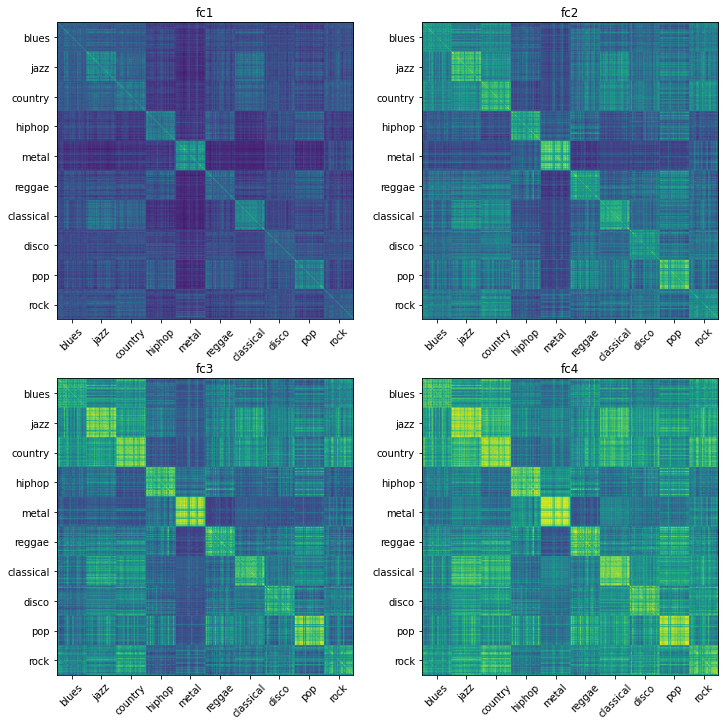

In [ ]:
fig,axes = plt.subplots(nrows=2, ncols=2)
count = 0
fig.set_figheight(12)
fig.set_figwidth(12)
emb_keys = list(sorted_embeddings.keys())
for ax in axes.reshape(-1):
  ax.set_title(emb_keys[count])
  im = ax.imshow(np.corrcoef(sorted_embeddings[emb_keys[count]]))
  ax.set_yticks(ticks=np.arange(50,1050,100))
  ax.set_yticklabels(labels=label_keys)
  ax.set_xticks(ticks=np.arange(50,1050,100))
  ax.set_xticklabels(labels=label_keys, rotation='45')
  count += 1

## PCA

### FC1

In [ ]:
pca_fc1 = sklearn.decomposition.PCA(n_components=100)

In [ ]:
pca_fc1.fit(sorted_embeddings['fc1'])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
explained_variance = pca_fc1.explained_variance_ratio_

In [ ]:
print(np.sum(explained_variance[:3]))

0.30327314


In [ ]:
fc1_pca_transformed = pca_fc1.transform(sorted_embeddings['fc1'])

In [ ]:
data = [[label_keys[sorted_labels[i]],fc1_pca_transformed[i,0],fc1_pca_transformed[i,1],fc1_pca_transformed[i,2]] for i in range(len(sorted_labels))]

In [ ]:
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC1_EMBEDDINGS',height=650,width=900)

### FC2

In [ ]:
pca_fc2 = sklearn.decomposition.PCA(n_components=100)

In [ ]:
pca_fc2.fit(sorted_embeddings['fc2'])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
explained_variance = pca_fc2.explained_variance_ratio_

In [ ]:
print(explained_variance[:10])

[0.27625155 0.13179933 0.0941839  0.08187607 0.05253131 0.0390168
 0.03665392 0.02726741 0.02200376 0.01218812]


In [ ]:
fc2_pca_transformed = pca_fc2.transform(sorted_embeddings['fc2'])

In [ ]:
data = [[label_keys[sorted_labels[i]],fc2_pca_transformed[i,0],fc2_pca_transformed[i,1],fc2_pca_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC2_EMBEDDINGS',height=650,width=900)

### FC3

In [ ]:
pca_fc3 = sklearn.decomposition.PCA(n_components=100)

In [ ]:
pca_fc3.fit(sorted_embeddings['fc3'])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
explained_variance = pca_fc3.explained_variance_ratio_

In [ ]:
print(explained_variance[:10],np.sum(explained_variance[:10]))

[0.2984788  0.16687433 0.13270013 0.10290451 0.05423094 0.05264664
 0.04138513 0.03204357 0.02419266 0.01897564] 0.92443234


In [ ]:
fc3_pca_transformed = pca_fc3.transform(sorted_embeddings['fc3'])

In [ ]:
data = [[label_keys[sorted_labels[i]],fc3_pca_transformed[i,0],fc3_pca_transformed[i,1],fc3_pca_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC3_EMBEDDINGS',height=650,width=900)

### FC4

In [ ]:
pca_fc4 = sklearn.decomposition.PCA(n_components=10)

In [ ]:
pca_fc4.fit(sorted_embeddings['fc4'])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
explained_variance = pca_fc4.explained_variance_ratio_

In [ ]:
print(explained_variance[:10],np.sum(explained_variance[:10]))

[0.30677307 0.21952057 0.14502724 0.10507036 0.0573567  0.05098667
 0.04478843 0.04138337 0.02805727 0.00103652] 1.0000002


In [ ]:
fc4_pca_transformed = pca_fc4.transform(sorted_embeddings['fc4'])

In [ ]:
data = [[label_keys[sorted_labels[i]],fc4_pca_transformed[i,0],fc4_pca_transformed[i,1],fc4_pca_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC4_EMBEDDINGS',height=650,width=900)

## t-SNE

### FC1

In [ ]:
tsne_fc1 = sklearn.manifold.TSNE(n_components=3)

In [ ]:
fc1_tsne_transformed = tsne_fc1.fit_transform(fc1_pca_transformed)

In [ ]:
data = [[label_keys[sorted_labels[i]],fc1_tsne_transformed[i,0],fc1_tsne_transformed[i,1],fc1_tsne_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC1_EMBEDDINGS',height=650,width=900)

### FC2

In [ ]:
tsne_fc2 = sklearn.manifold.TSNE(n_components=3)

In [ ]:
fc2_tsne_transformed = tsne_fc2.fit_transform(fc2_pca_transformed)

In [ ]:
data = [[label_keys[sorted_labels[i]],fc2_tsne_transformed[i,0],fc2_tsne_transformed[i,1],fc2_tsne_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC2_EMBEDDINGS',height=650,width=900)

### FC3

In [ ]:
tsne_fc3 = sklearn.manifold.TSNE(n_components=3)

In [ ]:
fc3_tsne_transformed = tsne_fc3.fit_transform(fc3_pca_transformed)

In [ ]:
data = [[label_keys[sorted_labels[i]],fc3_tsne_transformed[i,0],fc3_tsne_transformed[i,1],fc3_tsne_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC3_EMBEDDINGS',height=650,width=900)

### FC4

In [ ]:
tsne_fc4 = sklearn.manifold.TSNE(n_components=3)

In [ ]:
fc4_tsne_transformed = tsne_fc4.fit_transform(fc4_pca_transformed)

In [ ]:
data = [[label_keys[sorted_labels[i]],fc4_tsne_transformed[i,0],fc4_tsne_transformed[i,1],fc4_tsne_transformed[i,2]] for i in range(len(sorted_labels))]
df = pd.DataFrame(data=data,columns=['Genre','PC1','PC2','PC3'])

In [ ]:
px.scatter_3d(data_frame=df,x='PC1',y='PC2',z='PC3',color='Genre',title='FC4_EMBEDDINGS',height=650,width=900)

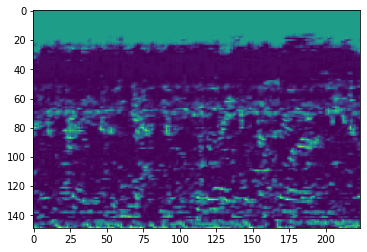

In [ ]:
plt.imshow(embeddings_dict['conv1'][0][5])

# VQ - VAE

## Dataset creation and loaders


In [ ]:
# audio_timeseries = load_pickle(drive_path+'sliced_timeseries_numpy.pickle')
# audio_labels = load_pickle(drive_path+'spectogram_label.pickle')

# min_size = np.array([a.shape[0] for a in audio_timeseries]).min()
# min_sized_audio = []
# for a in audio_timeseries:
#   min_sized_audio.append(a[:min_size].astype('float32'))
# del audio_timeseries
# audio_dataset_path = '/content/audio_hdf5_dataset/'
# if os.path.exists(audio_dataset_path):
#   shutil.rmtree(audio_dataset_path)
# os.mkdir(audio_dataset_path)
# hf = h5py.File(audio_dataset_path+'audio_f32_label_d64.h5','w')
# hf.create_dataset('audio',data=min_sized_audio)
# hf.create_dataset('labels',data=audio_labels.astype('int64'))
# hf.close()
# del audio_timeseries, audio_labels, min_size, min_sized_audio
# save_data('audio_hdf5_dataset',drive_path, data_folder=audio_dataset_path)

In [ ]:
load_zip(drive_path+'audio_hdf5_dataset.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class custom_h5_dataset_audio(torch.utils.data.Dataset):
  def __init__(self, in_file, normalize = False, to_tensor = True, n_channels = 1):
      super(custom_h5_dataset_audio, self).__init__()

      self.file = h5py.File(in_file, 'r')
      self.n_clips = self.file['audio'].shape[0]
      self.n_labels = self.file['labels'].shape[0]
      self.n_channels = n_channels
      self.to_tensor = to_tensor
      assert self.n_clips == self.n_labels

  def __getitem__(self, index):
      data = self.file['audio'][index]
      label = self.file['labels'][index]
      data = np.reshape(data,(1,data.shape[0]))
      data = torch.from_numpy(data.astype('float32'))
      return data, label

  def __len__(self):
      return self.n_clips

  def labels(self):
    return self.file['labels']

In [ ]:
def data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator, epoch_count=0):

  genres = dataset.labels()
  last_genre = genres[0]
  genre_index_split = []

  for i,genre in enumerate(genres):
    if genre != last_genre:
      last_genre = genre
      genre_index_split.append(i)
  genre_index_split.append(len(genres))

  # print(genre_index_split)

  dataset_size = len(dataset)
  indices = list(range(dataset_size))

  # genre_index_split = [1000, 2000, 3000, 4000, 5000, 6000, 6990, 7990, 8990, 9990]
  shuffle_dataset = True
  batch_size = batch_size

  train_indices, val_indices, test_indices = [],[],[]

  if shuffle_dataset :
    np.random.seed(seed)
    # np.random.shuffle(indices)
    last_index = 0
    for index in genre_index_split:
      test_array = []
      genre_indices = list(range(last_index,index))
      indices_length = len(genre_indices)

      train_size = int(train_split * indices_length)
      val_size = int(val_split * indices_length)
      test_size = indices_length - train_size - val_size

      train_start = 0
      train_end = train_start+train_size
      val_start = train_end
      val_end = val_start+val_size
      test_start = val_end
      test_end = test_start+test_size

      np.random.shuffle(genre_indices)
      for i in genre_indices[train_start:train_end]:
        train_indices.append(i)
      for i in genre_indices[val_start:val_end]:
        test_array.append(i)
        val_indices.append(i)
      for i in genre_indices[test_start:test_end]:
        test_indices.append(i)
      last_index = index
      # print(len(genre_indices))
      # print(len(train_indices),len(val_indices),len(test_indices))
      # print(test_array[:20])

  # Creating PT data samplers and loaders:
  train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices, generator=generator)
  valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices, generator=generator)
  test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices, generator=generator)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=0)
  return train_loader, validation_loader, test_loader


def view_data_loader(loader):
  labels_dict = {'blues': 0,
            'jazz': 1,
            'country': 2,
            'hiphop':3,
            'metal':4,
            'reggae':5,
            'classical':6,
            'disco':7,
            'pop':8,
            'rock':9}
  label_keys = labels_dict.keys()
  dataset = iter(loader)
  from IPython import display
  import time
  i = 0
  while i < len(dataset):
    data, label = dataset.next()
    for d in range(data.shape[0]):
      plt.imshow(data[d])
      plt.title(label_keys[label[d]])
      display.clear_output(wait=True)
      display.display(plt.gcf())
    i += 1
    print(i)

labels_dict = {'blues': 0,
            'jazz': 1,
            'country': 2,
            'hiphop':3,
            'metal':4,
            'reggae':5,
            'classical':6,
            'disco':7,
            'pop':8,
            'rock':9}
label_keys = list(labels_dict.keys())
label_values = list(labels_dict.values())

# audio_file_map = load_pickle('/content/drive/MyDrive/sliced_audio_name.pickle')

## Model

In [ ]:
# Reference: https://github.com/AntixK/PyTorch-VAE/blob/8700d245a9735640dda458db4cf40708caf2e77f/models/vq_vae.py#L7
# VQVAE Paper: https://arxiv.org/pdf/1711.00937.pdf

class ResidualLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
      super(ResidualLayer, self).__init__()
      self.resblock = torch.nn.Sequential(torch.nn.Conv1d(in_channels, out_channels,kernel_size=3, stride=1,padding=1, bias=False),
                                          torch.nn.ReLU(True),
                                          torch.nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False))

    def forward(self, input):
        return input + self.resblock(input)


class Encoder(torch.nn.Module):

  def __init__(self, in_channels, hidden_dims, embedding_dim):
    super(Encoder,self).__init__()
    self.in_channels = in_channels
    self.hidden_dims = hidden_dims
    self.embedding_dim = embedding_dim
    modules = []
    in_ch = self.in_channels
    for h_dim in self.hidden_dims:
      modules.append(
          torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=in_ch,out_channels=h_dim, kernel_size=4, stride=2,padding=1),
            torch.nn.LeakyReLU()
          )
      )
      in_ch = h_dim

    modules.append(
      nn.Sequential(
          nn.Conv1d(self.hidden_dims[-1], self.hidden_dims[-1],
                    kernel_size=3, stride=1, padding=1),
          nn.LeakyReLU())
    )


    for _ in range(6):
      modules.append(ResidualLayer(self.hidden_dims[-1],self.hidden_dims[-1]))

    modules.append(torch.nn.LeakyReLU())

    modules.append(
      torch.nn.Sequential(
          torch.nn.Conv1d(in_channels=self.hidden_dims[-1],out_channels=self.embedding_dim,
                    kernel_size=1, stride=1),
          torch.nn.LeakyReLU())
    )
    self.encode = torch.nn.Sequential(*modules)

  def forward(self,x):
    encoded_x = self.encode(x) #z
    return encoded_x           #z


class Decoder(torch.nn.Module):

  def __init__(self, embedding_dim, hidden_dims, out_channels):
    super(Decoder,self).__init__()

    self.in_channels = embedding_dim
    self.hidden_dims = hidden_dims
    self.hidden_dims.reverse()
    self.out_channels = out_channels
    modules = []

    modules.append(
      torch.nn.Sequential(
          torch.nn.ConvTranspose1d(in_channels=self.in_channels,out_channels=self.hidden_dims[0],
                    kernel_size=3, stride=1),
          torch.nn.LeakyReLU())
    )


    for _ in range(6):
      modules.append(ResidualLayer(self.hidden_dims[0],self.hidden_dims[0]))

    modules.append(torch.nn.LeakyReLU())

    in_ch = self.hidden_dims[0]
    for h_dim in self.hidden_dims[1:len(self.hidden_dims)]:
      modules.append(
          torch.nn.Sequential(
            torch.nn.ConvTranspose1d(in_channels=in_ch,out_channels=h_dim, kernel_size=4, stride=2,padding=1),
            torch.nn.LeakyReLU()
          )
      )
      in_ch = h_dim

    modules.append(
      torch.nn.Sequential(
          torch.nn.ConvTranspose1d(in_channels = in_ch,
                            out_channels=self.out_channels,
                            kernel_size=4,
                            stride=2,padding=57),
          torch.nn.Tanh()
      )
    )
    self.decode = nn.Sequential(*modules)

  def forward(self,z):
    decoded_z = self.decode(z)    #x'
    return decoded_z              #x'


class VectorQuantizer(torch.nn.Module):

  def __init__(self, embedding_dim, embedding_size, beta=0.25):
    super(VectorQuantizer,self).__init__()
    self.K = embedding_size
    self.D = embedding_dim
    self.beta = beta

    self.embedding = torch.nn.Embedding(num_embeddings=self.K,embedding_dim=self.D)
    self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)

  def forward(self, z):
    z = z.permute(0,2,1).contiguous()
    z_shape = z.shape
    flat_z = z.view(-1,self.D)

    # print(z_shape, flat_z.shape, self.embedding.weight.shape)
    #L2 Dist between z and emb weights
    dist = torch.sum(flat_z**2,dim=1,keepdim=True) + torch.sum(self.embedding.weight**2,dim=1) - 2 * torch.matmul(flat_z, self.embedding.weight.t())

    #Min dist encoding
    min_dist_encoding = torch.argmin(dist, dim=1).unsqueeze(1)

    device = z.device
    #one-hot encoding
    encoding_one_hot = torch.zeros(min_dist_encoding.size(0), self.K, device=device)
    encoding_one_hot.scatter_(1, min_dist_encoding, 1)

    # Quantize the latents
    quantized_z = torch.matmul(encoding_one_hot, self.embedding.weight)
    quantized_z = quantized_z.view(z_shape)

    # Compute the VQ Losses
    commitment_loss = torch.nn.functional.mse_loss(quantized_z.detach(), z)
    embedding_loss = torch.nn.functional.mse_loss(quantized_z, z.detach())

    vq_loss = commitment_loss * self.beta + embedding_loss

    # Add the residue back to the latents
    quantized_z = z + (quantized_z - z).detach()

    return quantized_z.permute(0,2,1).contiguous(), vq_loss


class VQVAE_audio(torch.nn.Module):
  def __init__(self, in_channels, embeddings_dim, embeddings_size, hidden_dims, beta=0.25):
    super(VQVAE_audio,self).__init__()
    self.in_channels = in_channels
    self.embeddings_dim = embeddings_dim
    self.embeddings_size = embeddings_size
    self.hidden_dims = hidden_dims
    self.beta = beta

    self.encoder = Encoder(in_channels=self.in_channels,hidden_dims=self.hidden_dims,embedding_dim=self.embeddings_dim)
    self.vectorquantizer = VectorQuantizer(embedding_dim=self.embeddings_dim, embedding_size=self.embeddings_size, beta=self.beta)
    self.decoder = Decoder(embedding_dim=self.embeddings_dim, hidden_dims=self.hidden_dims, out_channels=self.in_channels)

  def forward(self,x):
    z = self.encoder(x)
    vq_z, vq_loss = self.vectorquantizer(z)
    generated_x = self.decoder(vq_z)
    # print("zshapes: ",z.shape, vq_z.shape)
    # print("xshapes: ",x.shape,generated_x.shape)
    return generated_x, x, vq_loss, vq_z, z

  def loss(self, generated_x, x, vq_loss):
    recons_loss = torch.nn.functional.mse_loss(input=generated_x, target=x)
    total_loss = recons_loss + vq_loss
    return {'total_loss':total_loss,'recons_loss':recons_loss,'vq_loss':vq_loss}

## Train Loop

In [ ]:
def train(model, device, dataset, train_split, val_split, test_split, seed, generator, epochs, batch_size, lr = 0.0001, wandb_log = False, verbose = True):
  tracker = CarbonTracker(epochs=epochs)
  criterion =  model.loss
  # optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  all_train_predicted, all_train_target = [],[]
  all_val_predicted, all_val_target = [],[]
  if wandb_log:
    # 1. Start a new run
    wandb.init(project='Spectogram_Music', entity='indecisive_salmons')
    # 2. Save model inputs and hyperparameters
    config = wandb.config
    config.learning_rate = lr
    config.epochs = epochs
    config.criterion = criterion
    config.optimizer = optimizer
    config.batch_size = batch_size
    config.update({'Model Architecture':str(model)})
    # 3. Log gradients and model parameters
    wandb.watch(model)

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    epoch_count = 0
    for epoch in tepochs:
      tracker.epoch_start()
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      generator.manual_seed(seed+epoch_count)
      train_loader, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator,epoch_count)
      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        generated_x, x, vq_loss, vq_z, z = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss_dict  = criterion(generated_x, x, vq_loss)
        loss = loss_dict['total_loss']
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()
        tepochs.set_postfix({"total_loss":loss_dict['total_loss'].item(),"recons_loss":loss_dict['recons_loss'].item(),"vq_loss":loss_dict['vq_loss'].item()})
        if wandb_log:
          wandb.log({"total_loss":loss_dict['total_loss'].item(),"recons_loss":loss_dict['recons_loss'].item(),"vq_loss":loss_dict['vq_loss'].item()})
      # evaluate on validation data
      model.eval()
      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        generated_x, x, vq_loss, vq_z, z = model(data)
        loss_dict  = criterion(generated_x, x, vq_loss)
        loss = loss_dict['total_loss']
        tepochs.set_postfix({"val_total_loss":loss_dict['total_loss'].item(),"val_recons_loss":loss_dict['recons_loss'].item(),"val_vq_loss":loss_dict['vq_loss'].item()})
        if wandb_log:
          wandb.log({"val_total_loss":loss_dict['total_loss'].item(),"val_recons_loss":loss_dict['recons_loss'].item(),"val_vq_loss":loss_dict['vq_loss'].item()})
      epoch_count += 1
      # torch.cuda.empty_cache()
      tracker.epoch_end()
  tracker.stop()

In [ ]:
device = set_device()
generator = torch.Generator(device="cpu")

In [ ]:
dataset = custom_h5_dataset_audio('/content/audio_hdf5_dataset/audio_f32_label_d64.h5')

batch_size = 128 #Ensure you set batch size below or equal to 128
train_split = 0.7
val_split = 0.2
test_split = 0.1
lr = 0.01       # 0.00008 < lr < 0.0005, baseline = 0.00008
epochs = 70
seed = 42

#set verbose to True to print test and val accurracies per epoch
verbose = False
#set wandb_log to True to enable logging on https://wandb.ai/indecisive_salmons/Spectogram_Music
wandb_log = True

generator.manual_seed(seed)
# train_loader, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator)

# Train Model

In [ ]:
# del vqvae
# torch.cuda.empty_cache()

In [ ]:
vqvae = VQVAE_audio(in_channels=1, embeddings_dim=512, embeddings_size=100, hidden_dims=[8,32,64,128,256,512], beta=0.25).to(device)

In [ ]:
train(vqvae, device, dataset,train_split,val_split,test_split,seed=seed, generator=generator,
      epochs=epochs, batch_size=batch_size, lr=lr,
      wandb_log=wandb_log, verbose=verbose)

CarbonTracker: The following components were found: GPU with device(s) Tesla P100-PCIE-16GB.


wandb: Currently logged in as: thepilot (use `wandb login --relogin` to force relogin)


  0%|          | 0/70 [00:00<?, ?epoch/s]

RuntimeError: ignored

In [ ]:
save_model(vqvae,drive_path+'sweet-pine-134')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
summary(vqvae,(1,66000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 8, 33000]              40
         LeakyReLU-2             [-1, 8, 33000]               0
            Conv1d-3            [-1, 32, 16500]           1,056
         LeakyReLU-4            [-1, 32, 16500]               0
            Conv1d-5             [-1, 64, 8250]           8,256
         LeakyReLU-6             [-1, 64, 8250]               0
            Conv1d-7            [-1, 128, 4125]          32,896
         LeakyReLU-8            [-1, 128, 4125]               0
            Conv1d-9            [-1, 256, 2062]         131,328
        LeakyReLU-10            [-1, 256, 2062]               0
           Conv1d-11            [-1, 512, 1031]         524,800
        LeakyReLU-12            [-1, 512, 1031]               0
           Conv1d-13            [-1, 512, 1031]         786,944
        LeakyReLU-14            [-1, 51

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



TypeError: ignored

In [ ]:
train_loader, validation_loader, test_loader = data_loaders(dataset, train_split, val_split, test_split, seed, batch_size, generator)

In [ ]:
len(test_loader)

16

In [ ]:
audio_in = []
count = 0
for a,l in test_loader:
  audio_in.append(a)
  if count > 5:
    break
  count += 1

In [ ]:
audio_in[0]

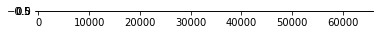

In [ ]:
plt.imshow(audio_in[0][0])

In [ ]:
torch.var(audio_in[0][0][0])

tensor(0.0801)

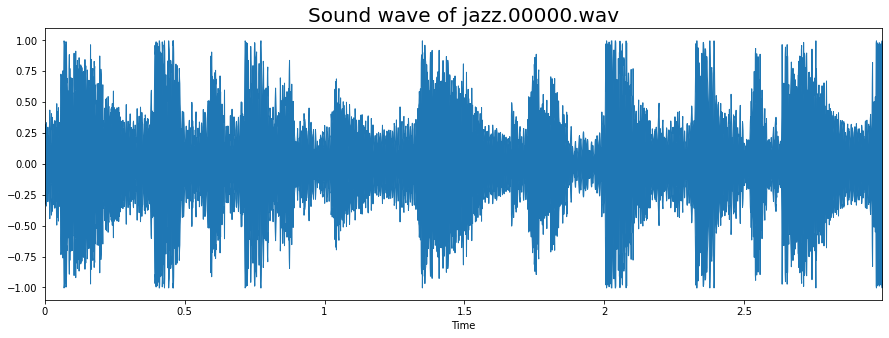

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y=audio_in[0][0][0].numpy());
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

In [ ]:
vqvae.eval()
input = audio_in[0].to(device)
generated_x, x, vq_loss, vq_z, z = vqvae(input)

In [ ]:
gen_numpy = generated_x.detach().cpu().numpy()

In [ ]:
gen_numpy.shape

(64, 1, 66000)

In [ ]:
gen_numpy[0][0].shape

(66000,)

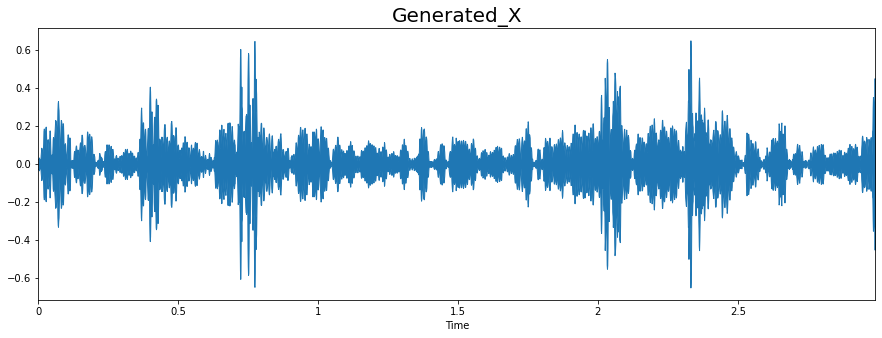

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y=gen_numpy[0][0]);
plt.title("Generated_X", fontsize=20)
plt.show()

In [ ]:
import soundfile as sf

In [ ]:
music_path = '/content/generated_music2/'
os.mkdir('/content/generated_music2/')


RuntimeError: ignored

In [ ]:
save_data('first_generated_audio',drive_path, data_folder=music_path)

Mounted at /content/drive


  0%|          | 0/1 [00:00<?, ?it/s]

(4224000,)

In [ ]:
sf.write(music_path+'gen_sample.wav',np.concatenate(gen_numpy,axis=-1)[0],22050)

In [ ]:
save_data('generated_audio',drive_path, data_folder=music_path)

Mounted at /content/drive


  0%|          | 0/2 [00:00<?, ?it/s]